In [1]:
%cd ..
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from melp import Detector
import melp
import math

from melp.clustering.misc import*
import melp.clustering as clump
import melp.clustering.time_cluster as tclump
#from melp import TileAnalyzer
import melp.clustering.spatial_cluster as sclump
import melp.clustering.plots as clump_plt
import melp.clustering.three_frame_cluster as clump_3

plt.rcParams.update({'font.size': 16})

/home/erik/GitHub/melp
Welcome to JupyROOT 6.24/06


#### Load files

In [2]:
filename_trirec = "./testdata/trirec/trirec1.root"
filename_sorted = "./testdata/sorted/sorted1.root"
filename_sorted_big = "/home/erik/GitLab_KIP/melp/root_files/big_run_data/sorted1.root"
#filename_sorted_big = "./testdata/sorted/sorted1_big.root"

file = ROOT.TFile(filename_sorted)
ttree_mu3e = file.Get("mu3e")
ttree_mu3e_mc = file.Get("mu3e_mchits")
ttree_sensor = file.Get("alignment/sensors")
ttree_tiles = file.Get("alignment/tiles")

file_rec = ROOT.TFile(filename_trirec)
ttree_trirec = file_rec.Get("frames")
ttree_trirec_mc = file_rec.Get("frames_mc")
ttree_mu3e_segs = file_rec.Get("segs")

file_big = ROOT.TFile(filename_sorted_big)
ttree_mu3e_big = file_big.Get("mu3e")
ttree_mu3e_mc_big = file_big.Get("mu3e_mchits")
ttree_sensor_big = file_big.Get("alignment/sensors")
ttree_tiles_big = file_big.Get("alignment/tiles")

In [3]:
mu3e_detector = Detector.initFromROOT(filename_sorted)

------------------------------
Detector information

Stats:
  - Tiles:  5824
    -> misal:  False
  - Pixel Modules:  2844
  - Loaded Runs (Tiles):  []
  - Loaded Runs (Pixel):  []
------------------------------


In [4]:
melp.select(mu3e_detector)
print(mu3e_detector)

Detector(TileDetector=<melp.src.tile.TileDetector object at 0x7f6d95e71400>, SensorModules=<melp.src.sensor.SensorModule object at 0x7f6d940841c0>))


In [5]:
melp.addTileHits("./testdata/sorted/sorted1.root", truth=False, traj=False)
mu3e_detector.info()

------------------------------
Detector information

Stats:
  - Tiles:  5824
    -> misal:  False
  - Pixel Modules:  2844
  - Loaded Runs (Tiles):  [1]
  - Loaded Runs (Pixel):  []
------------------------------


In [6]:
#select frame to analyze
frame_used = 182 #28 #30
ttree_mu3e.GetEntry(frame_used)

#build masks (and deconstruct them into arrays)
#masks = sclump.build_mask_detector_class(filename_sorted, frame_used, mu3e_detector, mask_type = "big")
masks = clump_3.build_mask_around_cluster_master_frame_id(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles, mu3e_detector, frame_used, mask_type = "big")

keys = []
values = []
for key in masks.keys():
    keys.append(key)
    values.append(masks[key])
    
#mu3e_detector.TileDetector.tile[keys[0]].id
#mu3e_detector.TileDetector.tile[keys[0]].hits
#print(len(masks))

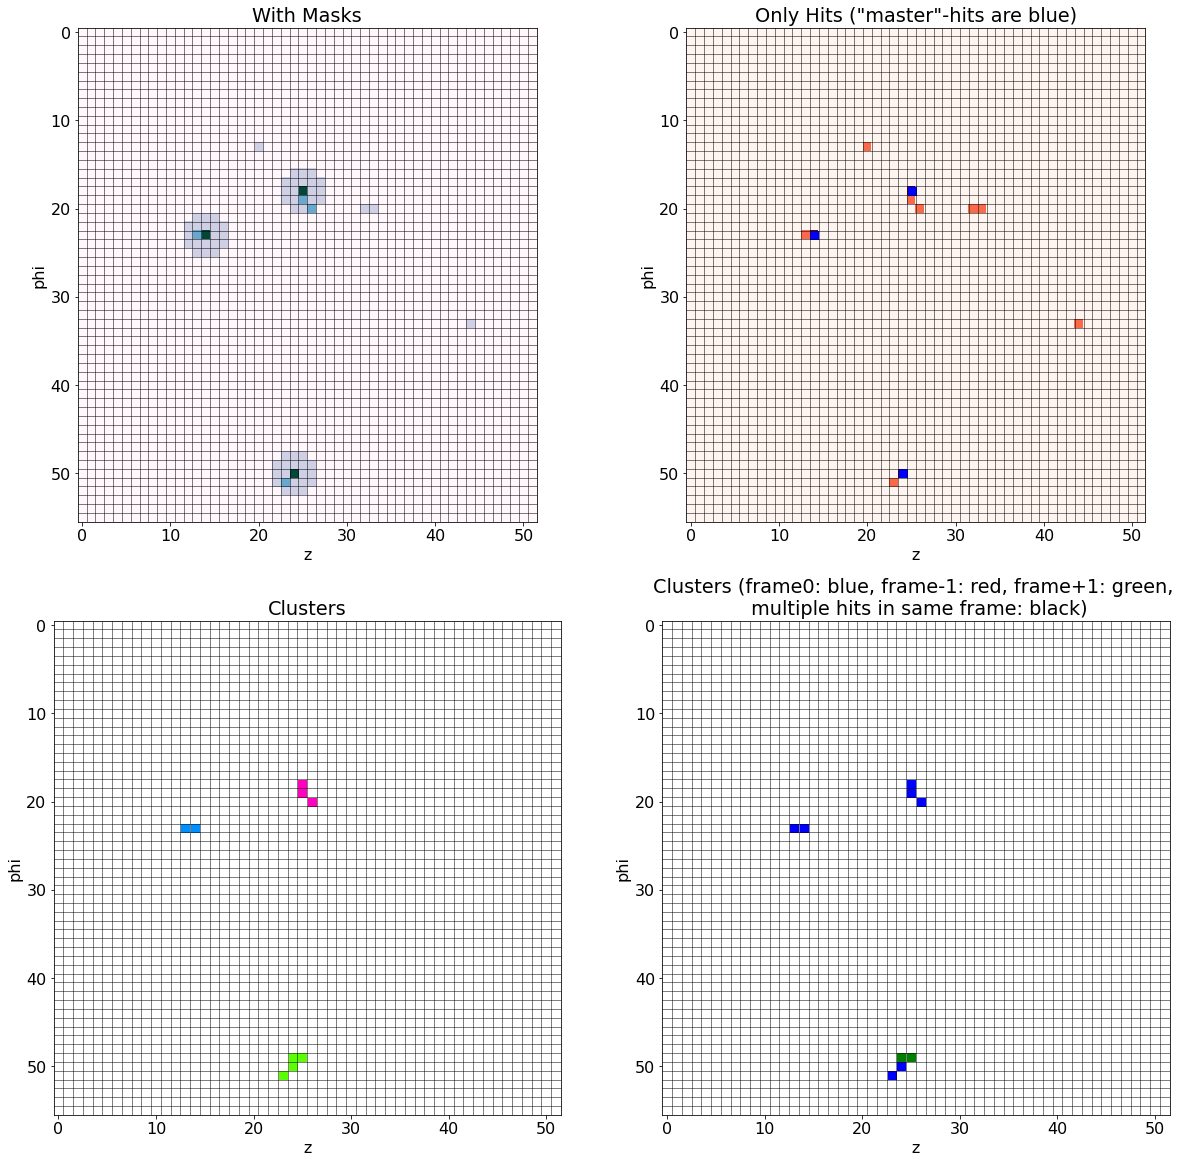

[182.0, 183.0]


In [7]:
grid = np.zeros((52,56))

#Choose if a single hit is plotted of all hits in frame (True, False)
all_hits = True

#If single hit is chosen. Choose hit to plot
single_hit = 1

#add hits in frame
if all_hits == True:
    for tile_id in mu3e_detector.TileDetector.tile:
        if tile_id < 300000:
            tile = mu3e_detector.TileDetector.tile[tile_id]
            for hits in tile.hits:
                if hits.frame_id in [frame_used]:
                    y = tile.row()
                    x = tile.column()
                    grid[x][y] += 1


#add masks
if all_hits == True:
    for i in range(len(values)):
        for mask_tile in values[i]:
            tile = mu3e_detector.TileDetector.tile[mask_tile[0]]
            if mask_tile[0] < 300000:
                y = tile.row()
                x = tile.column()
                grid[x][y] += 1

        #add centre a second and third time      
        if keys[i] < 300000:
            tile = mu3e_detector.TileDetector.tile[keys[i]]
            y = tile.row()
            x = tile.column()
            grid[x][y] += 2
                     
if all_hits == False:
    for mask_tile in values[single_hit]:
        tile = mu3e_detector.TileDetector.tile[mask_tile]
        if mask_tile < 300000:
            y = tile.row()
            x = tile.column()
            grid[x][y] += 1

    #add centre a second and third time      
    if keys[single_hit] < 300000:
        tile = mu3e_detector.TileDetector.tile[keys[single_hit]]
        y = tile.row()
        x = tile.column()
        grid[x][y] += 2
                
fig, ax = plt.subplots(2,2, figsize=(20,20))
#heatplot_mask = ax.imshow(mask_grid.T, cmap='binary')
heatplot = ax[0,0].imshow(grid.T, cmap='PuBuGn')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[0,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,0].set_title("With Masks")
ax[0,0].set_xlabel("z")
ax[0,0].set_ylabel("phi")


#plot reference
ref_grid = np.zeros((52,56))
for tile_id in mu3e_detector.TileDetector.tile:
    if tile_id < 300000:
        tile = mu3e_detector.TileDetector.tile[tile_id]
        for hits in tile.hits:
            if hits.frame_id in [frame_used]:
                y = tile.row()
                x = tile.column()
                ref_grid[x][y] += 1
                
#plot primary hits into reference plot(truth)
cluster_primary = get_cluster_primary_truth_and_frame_id(ttree_mu3e, ttree_mu3e_mc, frame_used)  
    
for i in range(len(cluster_primary)):
    primary = mu3e_detector.TileDetector.tile[cluster_primary[i][0]]
    if primary.id < 300000:
        y = primary.row()
        x = primary.column()
        ax[0,1].scatter(x,y, color = "blue", marker = "s", s = 64)
        ref_grid[x][y] += 1


heatplot = ax[0,1].imshow(ref_grid.T, cmap='Reds')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[0,1].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,1].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,1].set_title("Only Hits (\"master\"-hits are blue)")
ax[0,1].set_xlabel("z")
ax[0,1].set_ylabel("phi")


#plot clusters
cluster_grid = np.zeros((52,56))
clusters = clump_3.build_clusters_in_masks_with_neighbours(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles, mu3e_detector, frame_used, mask_type = "big")
cluster_primaries = []
whole_clusters = []

for key in clusters.keys():
    cluster_primaries.append(key)
    whole_clusters.append(clusters[key])    
    
color_cluster = 1
for i in range(len(clusters)):
    color_cluster += 1
    for cluster_tile in whole_clusters[i]:
        tile = mu3e_detector.TileDetector.tile[cluster_tile[0]] 
        if cluster_tile[0] < 300000:
            y = tile.row()
            x = tile.column()
            cluster_grid[x][y] += color_cluster

rainbow = cm.get_cmap('gist_rainbow',  int(np.max(cluster_grid)))
newcolors = rainbow(np.linspace(0, 1,  int(np.max(cluster_grid))))
white = np.array([1, 1, 1, 1])
newcolors[:1, :] = white
newcmp = ListedColormap(newcolors)

colors = newcmp(np.linspace(0, 1, int(np.max(cluster_grid))+2)) 
for i in range(int(np.max(cluster_grid))+2):
    for x in range(np.shape(cluster_grid)[0]):
        for y in range(np.shape(cluster_grid)[1]):
            if cluster_grid[x][y] == i and i > 0:
                ax[1,0].scatter(x, y, color = colors[i], marker = "s", s = 64)

                
#heatplot = ax[1,0].imshow(cluster_grid.T, cmap='Reds')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[1,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[1,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[1,0].set_title("Clusters")
ax[1,0].set_xlabel("z")
ax[1,0].set_ylabel("phi")
ax[1,0].set_xlim(-0.5,51.5)
ax[1,0].set_ylim(-0.5,55.5)
ax[1,0].invert_yaxis()

#plot clusters colored by frame id
frame_id_grid = np.zeros((52,56))
#clusters = clump_3.build_clusters_in_masks_with_neighbours(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles, mu3e_detector, frame_used, mask_type = "big")
#cluster_primaries = []
#whole_clusters = []

for key in clusters.keys():
    cluster_primaries.append(key)
    whole_clusters.append(clusters[key]) 

for i in range(len(clusters)):
    for cluster_tile in whole_clusters[i]:
        tile = mu3e_detector.TileDetector.tile[cluster_tile[0]] 
        if cluster_tile[0] < 300000:
            y = tile.row()
            x = tile.column()
            frame_id_grid[x][y] += cluster_tile[1]
            
for x in range(np.shape(frame_id_grid)[0]):
    for y in range(np.shape(frame_id_grid)[1]):
        if frame_id_grid[x][y] == frame_used - 1:
            ax[1,1].scatter(x, y, color = "red", marker = "s", s = 64)
        elif frame_id_grid[x][y] == frame_used:
            ax[1,1].scatter(x, y, color = "blue", marker = "s", s = 64)
        elif frame_id_grid[x][y] == frame_used + 1:
            ax[1,1].scatter(x, y, color = "green", marker = "s", s = 64)
        elif frame_id_grid[x][y] == (frame_used-1) + (frame_used):
            ax[1,1].scatter(x, y, color = "purple", marker = "s", s = 64)
        elif frame_id_grid[x][y] == (frame_used-1) + (frame_used+1):
            ax[1,1].scatter(x, y, color = "sienna", marker = "s", s = 64)
        elif frame_id_grid[x][y] == (frame_used) + (frame_used+1):
            ax[1,1].scatter(x, y, color = "deepskyblue", marker = "s", s = 64)
        elif frame_id_grid[x][y] == (frame_used) + (frame_used+1)+ (frame_used-1):
            ax[1,1].scatter(x, y, color = "olive", marker = "s", s = 64)
        elif frame_id_grid[x][y] > 0:
            ax[1,1].scatter(x, y, color = "black", marker = "s", s = 64)



            
ax[1,1].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[1,1].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[1,1].set_title("Clusters (frame0: blue, frame-1: red, frame+1: green, \n multiple hits in same frame: black)")
ax[1,1].set_xlabel("z")
ax[1,1].set_ylabel("phi")
ax[1,1].set_xlim(-0.5,51.5)
ax[1,1].set_ylim(-0.5,55.5)
ax[1,1].invert_yaxis()
plt.savefig("hitmap.png")
plt.show()

#print values in frame_id_grid
grid_values = []
for x in range(np.shape(frame_id_grid)[0]):
    for y in range(np.shape(frame_id_grid)[1]):
        if frame_id_grid[x][y] != 0 and frame_id_grid[x][y] not in grid_values:
            grid_values.append(frame_id_grid[x][y])
print(grid_values)

In [8]:
masks = clump_3.build_mask_around_cluster_master_frame_id(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles, mu3e_detector, frame_used, mask_type = "big", rec_type = None)

In [9]:
frac_mult_frame_cluster_hits, total_cluster_hits_counter, mult_frame_cluster_hits_counter = clump_3.check_for_multiple_frame_clusters(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big, mu3e_detector, mask_type = "big", number_of_frames = 1000, rec_type = None)

Progress: 100 % of  1000  frames
Hits in cluster in different frame than master out of all hits in clusters:  5.772347587582596 %


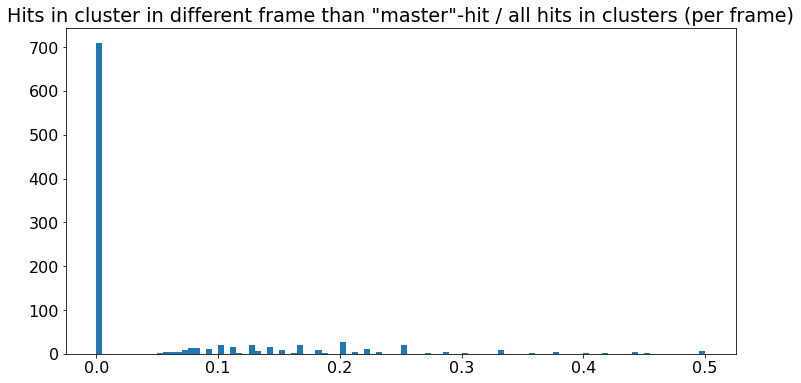

In [10]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_mult_frame_cluster_hits, bins = 100)
plt.title("Hits in cluster in different frame than \"master\"-hit / all hits in clusters (per frame)")
plt.show()

In [11]:
print(total_cluster_hits_counter)
print(mult_frame_cluster_hits_counter)

8021
463


In [12]:
double_hit_counter, total_cluster_hits_counter = clump_3.check_for_mult_hit_tiles_diff_frame(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big, mu3e_detector, mask_type = "big", number_of_frames = 1000, rec_type = None)

Tiles in cluster hit in multiple frames out of all hits in clusters:  0.12467273407305823 %


In [13]:
hits_all_frames, hits_all_frames_counter_after = clump_3.del_double_hits_in_3_frame_cluster(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big, mu3e_detector, mask_type = "big", number_of_frames = 1000, rec_type = None)

Progress of building dictionary with all hits: 100 % of  1000  frames
Progress of removing double hits: 100 % of  1000  frames
Number of hits before removing doubles:  15606
Number of hits after removing doubles:  15151
Number of removed hits:  455


In [14]:
frac_not_in_3cluster = clump_plt.get_hits_not_in_cluster_3_frame(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big,  mu3e_detector, mask_type = "big", number_of_frames = 1000, rec_type = None)

Progress of building dictionary with all hits: 100 % of  1000  frames
Progress of removing double hits: 100 % of  1000  frames
Number of hits before removing doubles:  15606
Number of hits after removing doubles:  15151
Number of removed hits:  455
Progress: 100 % of  1000  frames
Not associated hits out of all hits:  52.874397729522805 %
17


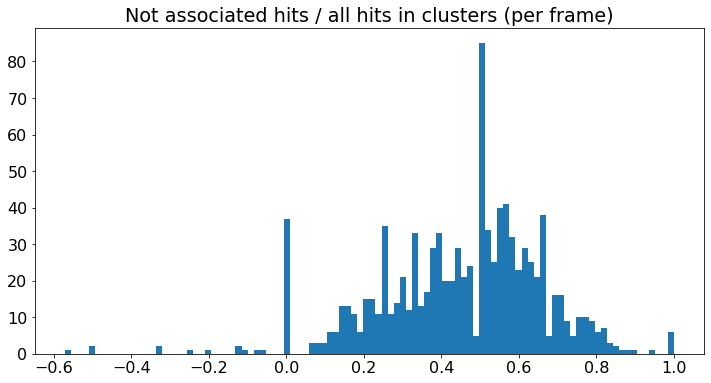

In [15]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_not_in_3cluster, bins = 100)
plt.title("Not associated hits / all hits in clusters (per frame)")
plt.show()

In [16]:
clusters = clump_3.build_clusters_in_masks_with_neighbours(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big,  mu3e_detector, frame_used, mask_type = "big", rec_type = None)

In [17]:
print(clusters)

{202523: [[202523, 182], [202410, 181]], 202397: [[202397, 182]], 300880: [[300880, 182]], 301408: [[301408, 182]]}


In [18]:
clusters_with_primaries = clump_3.build_cluster_with_truth_primary_3_frame(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big,  mu3e_detector, frame_used, mask_type = "big", rec_type = None)

In [19]:
print(clusters_with_primaries)

{154137: [154137, 109884], 110960: [110960], 150567: [150567], 145074: [145074]}


In [20]:
frac_corr_frame, frac_corr_clusters_frame, frac_uncorr_frame, tot_corr_counter = clump_plt.compare_to_primary_3_frames(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big,  mu3e_detector, mask_type = "big", number_of_frames = 50000, rec_type = None)

Progress of building dictionary with all hits: 100 % of  50000  framesmes
Progress of removing double hits: 100 % of  50000  framesmes
Number of hits before removing doubles:  783364
Number of hits after removing doubles:  759430
Number of removed hits:  23934
Progress: 100 % of  50000  framesmes
Total #hits in frames/#hits in clusters =  2.658091387970109
Correctly associated out of all hits 64.87865899424568 %
Incorrectly associated out of all hits 5.181649394940942 %


### Hits correctly associated (comparing to primary)

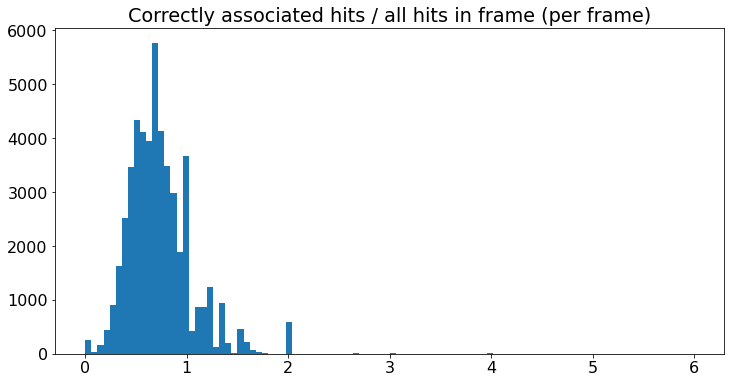

In [21]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_frame, bins = 100)
plt.title("Correctly associated hits / all hits in frame (per frame)")
plt.show()

### Hits incorrectly associated (comparing to primary)

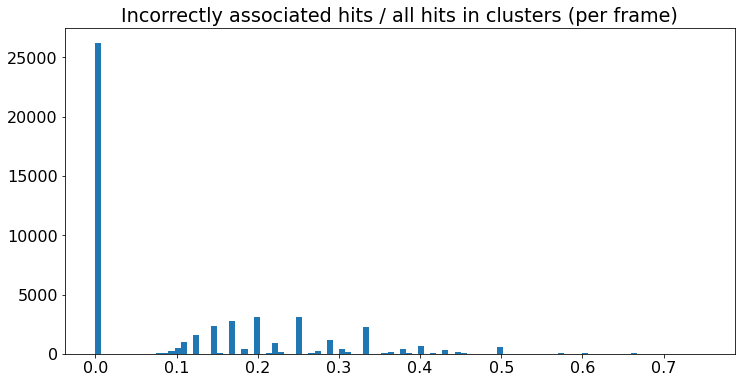

In [22]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_uncorr_frame, bins = 100)
plt.title("Incorrectly associated hits / all hits in clusters (per frame)")
plt.show()

### Combined Histogram

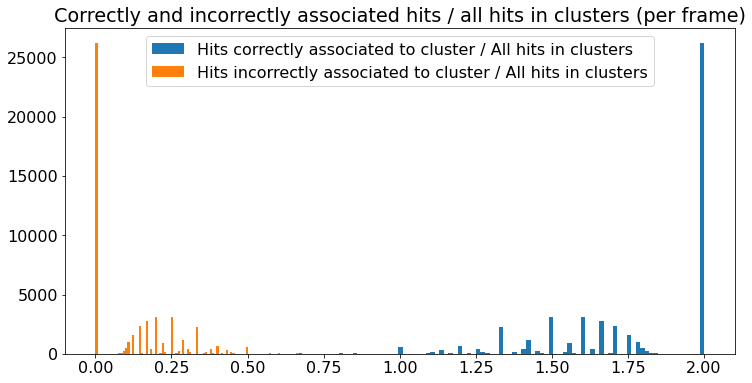

In [23]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_clusters_frame, bins = 100, label = "Hits correctly associated to cluster / All hits in clusters")
plt.hist(frac_uncorr_frame, bins = 100, label = "Hits incorrectly associated to cluster / All hits in clusters")
plt.title("Correctly and incorrectly associated hits / all hits in clusters (per frame)")
plt.legend()
plt.show()